<a target="_blank" href="https://colab.research.google.com/github/abyildirim/pytorch-tutorials/blob/main/2_cnn_classifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# PyTorch Convolutional Neural Network (CNN) Tutorial

In this notebook, a simple convolutional neural network is implemented by using the PyTorch library to perform multi-class classification on the [Animal Faces HQ (AFHQ)](https://www.kaggle.com/datasets/andrewmvd/animal-faces) dataset. There are three types of classes defined in this dataset, which are cat, dog, and wildlife. Each class has images at 512×512 resolution in the original dataset. For simplicity, the resolution of the images is decreased to 64x64, and a compatible CNN architecture is designed and implemented accordingly for the classification task.

### Importing the Libraries Required

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### Setting Library Seeds for Reproducibility

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
seed_everything(464) # The seed number is selected arbitrarily

### GPU Support Check

The parallel computing power of GPUs is commonly used in neural network training because it increases the speed of the training process significantly. PyTorch supports CUDA, which is developed by NVIDIA and used to communicate with CUDA-enabled GPUs to run calculations on them. To be able to use CUDA, the [PyTorch library with CUDA support](https://pytorch.org/get-started/locally/), [CUDA Toolkit](https://developer.nvidia.com/cuda-downloads), and one of the NVIDIA's GPUs that supports CUDA should be installed in the environment. If these requirements are satisfied, the following code can be run to verify that CUDA is available.

**Note:** Colab already satisfies the requirements without any additional needs. However, it opens the notebooks on a CPU runtime by default. To allocate a runtime with GPU, click "Runtime" and "Change runtime type" from the menu bar, then select GPU from the dropdown list.

In [4]:
is_cuda_available = torch.cuda.is_available()
print("Is CUDA available: {}".format(is_cuda_available))
if is_cuda_available:
    num_gpus = torch.cuda.device_count()
    print("There are {} GPU(s) available".format(num_gpus))
    for gpu_id in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(gpu_id)
        print(f"Name of GPU {gpu_id}: {gpu_name}")

Is CUDA available: True
There are 1 GPU(s) available
Name of GPU 0: Tesla T4


#### NVIDIA System Management Interface (SMI)

The NVIDIA System Management Interface provides a command line interface to observe the GPU stats of the environment and can be run using the following command prompt.

In [5]:
!nvidia-smi

Fri May 12 16:30:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Preparing the Dataset

As stated before, the CNN model is trained on the downsampled version of the [AFHQ dataset](https://www.kaggle.com/datasets/andrewmvd/animal-faces) in this tutorial, which can be downloaded from [Google Drive](https://drive.google.com/file/d/1aRkgdSxuorI_hFjg-iCiCeVy_9fR9kCO/view?usp=share_link). After downloading the dataset, it should be extracted to the directory of the notebook file so that the image reading operations can run properly. Colab users can uncomment the cell below to complete these steps automatically. 

Since there are only training and validation splits provided in the dataset, the model is trained on the training set and evaluated on the validation set. Keep it in mind that the network hyperparameters should be tuned on a validation set and the performance of the model should be reported on the test set as a usual practice. However, the process is simplified in this tutorial. 

**Note:** The downsampled dataset is created by resizing the original dataset from 512x512 to 64x64 using the resize function of the PIL library with bicubic interpolation. It is licensed under the terms and conditions of [CC BY-NC 4.0](https://creativecommons.org/licenses/by-nc/4.0/).

In [6]:
import gdown # Library to download files from Google Drive
!gdown 1aRkgdSxuorI_hFjg-iCiCeVy_9fR9kCO # Google Drive ID of the zip file to be downloaded
!unzip -oq afhq_64 # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1aRkgdSxuorI_hFjg-iCiCeVy_9fR9kCO
To: /content/afhq_64.zip
100% 29.0M/29.0M [00:00<00:00, 42.6MB/s]


### Implementing a Custom Dataset

The custom dataset class is defined below, which inherits the Dataset class of PyTorch. There are two methods required to be overwritten in this class. First one is the \_\_len\_\_ method. It should return the number of total samples in the dataset. The second one is the \_\_getitem\_\_ method, which returns a sample data. It can return multiple data for a sample if needed for the task.

Since keeping all dataset samples in the memory can exceed the limits, especially for the high-resolution datasets, only the paths of the images are kept in an array when the constructor \_\_init\_\_ is called, i.e. a dataset object is created. The paths of the dataset images are found by using the os library of Python. Also, the transform operation is defined in the constructor to convert the readed images into tensor object and normalize their values. [ToTensor()](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) converts the input data, a NumPy array or a PIL Image object, into a tensor object in the range \[0, 1\]. [Normalize(channel_mean_list, channel_std_list)](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) normalizes each channel of the tensor data by the provided mean and standard deviation values. [Compose(transform_1, transform_2, ...)](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) creates a pipeline of the transform operations to apply them sequentially.

Images of each class exist under the class folder in this dataset. In the constructor, the image paths and their corresponding classes are kept in two different lists. \_\_len\_\_ returns the length of the image path list, which is equal to the number of total images in the dataset. \_\_getitem\_\_ takes a data ID and returns the corresponding data. The image path and its class are retrieved from the lists created in the constructor by the provided ID. Using the PIL library, the image is read from its file path and then converted to a tensor by calling the transform function defined in the constructor. In the end, both the image tensor and its class are returned.

In [7]:
class AFHQDataset(Dataset):
    def __init__(self, root_dir):
        class_names = ["cat", "dog", "wild"]
        self.class_list = []
        self.image_path_list = []
        
        for class_id, class_name in enumerate(class_names): 
            class_dir = os.path.join(root_dir, class_name)
            image_files = os.listdir(class_dir)
            image_paths = [os.path.join(class_dir, image_file) for image_file in image_files]
            self.image_path_list.extend(image_paths)
            self.class_list.extend([class_id]*len(image_paths))
            
        self.transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, data_id):
        image_path = self.image_path_list[data_id]
        image_class = self.class_list[data_id]
        image = Image.open(image_path)
        image_tensor = self.transform(image)
        return image_class, image_tensor

The dataset objects for the training and validation datasets are created below by providing their root directory. Later, [DataLoader](https://pytorch.org/docs/stable/data.html) objects are created for these dataset objects to be able to load the data efficiently. The details are explained in the provided link. 

In short, a DataLoader object retrieves data from a dataset object by chunk-reading, which yields a batched sample at each iteration. It first gets the length of the dataset by calling the \_\_len\_\_ method of the dataset. Then, from 0 to the length, it generates chunks of data_id with the size of batch_size and retrieves batched samples by passing data IDs of each chunk to the \_\_getitem\_\_ method of the dataset object. If shuffle is set to True, these data IDs are shuffled before creating chunks.

In [8]:
train_dataset = AFHQDataset(root_dir='./afhq_64/train')
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = AFHQDataset(root_dir='./afhq_64/val')
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=False)

A subset of training data samples is visualized below.

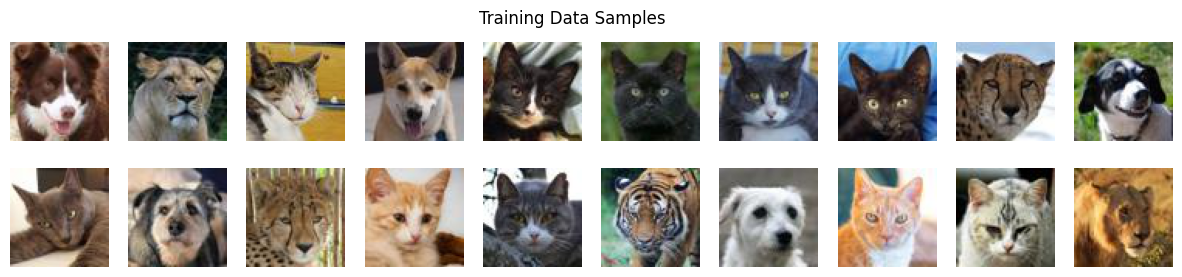

In [9]:
_, images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = images.numpy()

num_rows = 2
num_columns = 10

figure, axis_array = plt.subplots(num_rows, num_columns, figsize=(num_columns*1.5,num_rows*1.5))
figure.suptitle("Training Data Samples")

im_id = 0
for row_id in range(num_rows):
  for column_id in range(num_columns):
    # The channel dimension of the image is moved to the last index 
    # to make the shape of the image compatible with Matplotlib
    image = images[im_id].transpose(1,2,0) 
    # Value range is mapped from [-1,1] to [0,1]
    image = (image + 1) / 2
    if num_rows == 1:
      current_axis = axis_array[column_id]
    else:
      current_axis = axis_array[row_id, column_id]
    current_axis.axis('off')
    current_axis.imshow(image)
    im_id += 1

### Constructing a Classifier Network

A simple classifier is defined by inheriting [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class of PyTorch. Inside the constructor, various modules are defined to construct a classifier network:

* [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) creates a pipeline of modules and passes the input sequentially in order. 
* [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) applies 2D convolution operation.
* [nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) applies batch normalization, which standardizes the layer activations and stabilizes the training process.
* [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) is the rectified linear unit layer used as an activation function.
* [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) applies the 2D max pooling operation that extracts important activations.
* [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) is a flattening function that keeps the batch dimension and flattens the rest of the dimensions. 
* [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is a fully connected layer.
* [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) is the sigmoid activation function but it is used to output probabilities for the classes by mapping the output values into the range from 0 to 1 in the last layer.

The architecture of the classifier and the sizes of the activations are shown in the below figure, which is created using [this website](http://alexlenail.me/NN-SVG/AlexNet.html).

![AFHQ classifier architecture](https://drive.google.com/uc?export=view&id=1ZX8_xeraLcOfG-VPHv71q05We7F8gzD_)

In a module class, a forward method should be defined to apply the forward pass. In the implementation below, the forward method calls the defined layers in order to calculate the prediction values.

In [10]:
class AFHQ_Classifier(nn.Module):
    def __init__(self):
        super(AFHQ_Classifier, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=4096, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=3)
        )
            
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # B: Batch size
        x = self.conv_block_1(x)  # Bx3x64x64 --> Bx16x32x32
        x = self.conv_block_2(x)  # Bx16x32x32 --> Bx32x16x16
        x = self.conv_block_3(x)  # Bx32x16x16 --> Bx64x8x8
        x = self.flatten(x)       # Bx64x8x8 --> Bx4096
        x = self.fc_layers(x)     # Bx4096 --> Bx128 --> Bx64 --> Bx3
        x = self.sigmoid(x)       # Bx3 --> Bx3
        return x

### Implementing the Training Loop

Before starting the training loop, the loss function is defined as [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) to perform multi-class classification. The model is initialized and sent to GPU by calling cuda() if CUDA is available. The learning rate is set to 0.0002 and an [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer is created, which updates the learning rate in the training phase as the other optimizer methods do to converge the objective faster. Learning rates are updated for each network parameter separately. Adam takes the parameters of the model and the initial learning rate as arguments.

In [11]:
loss_func = nn.CrossEntropyLoss()
model = AFHQ_Classifier()
if is_cuda_available:
    model.cuda()
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

The [tqdm](https://github.com/tqdm/tqdm) library is used to visualize the progress % of the training loop. At the beginning of the training loop, the batch data is moved to GPU if CUDA is available. Note that the data and the model should be in the same device, which can be GPU or CPU, to be able to apply forward pass. 

[zero_grad()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) function is called to remove the gradients of the model parameters calculated in the previous iteration by setting them to zero. The model parameters were given to the optimizer above. After finding the loss value between the predicted and the ground truth classes, the [backward()](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) function is called to calculate the gradients of the model parameters automatically.

**Note:** If the zero_grad() function is not called, the backward() function accumulates the new gradients. 

[step()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) function updates the model parameters with the gradients calculated. Also, the loss values are appended to the lists to report them after the training loop ends. Before appending the loss values, [item()](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html) is called to convert the tensor object to a standard Python number.

In [12]:
from tqdm import tqdm

num_batches = len(train_dataloader)
num_epochs = 10
iter_losses = []
epoch_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Progress", total=num_epochs, position=0, leave=True): 
    total_iter_loss = 0.0
    for image_class_batch, image_tensor_batch in tqdm(train_dataloader, desc=f"Epoch: {epoch+1}", total=num_batches, position=0, leave=True):
        if is_cuda_available:
            image_tensor_batch = image_tensor_batch.cuda()
            image_class_batch = image_class_batch.cuda()
            
        optimizer.zero_grad()
        batch_output = model(image_tensor_batch)
        loss = loss_func(batch_output, image_class_batch)
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        total_iter_loss += loss.item()
    epoch_loss = total_iter_loss / num_batches
    epoch_losses.append(epoch_loss)
    print(f"\nEpoch {epoch+1} Loss: {epoch_loss}")

print("Training is finished!")

Training Progress:  10%|█         | 1/10 [00:20<03:05, 20.66s/it]


Epoch 1 Loss: 0.7806707584339639


Training Progress:  20%|██        | 2/10 [00:32<02:01, 15.24s/it]


Epoch 2 Loss: 0.6246952673663264


Training Progress:  30%|███       | 3/10 [00:43<01:34, 13.55s/it]


Epoch 3 Loss: 0.5992203038671743


Training Progress:  40%|████      | 4/10 [00:54<01:16, 12.67s/it]


Epoch 4 Loss: 0.5871490504430688


Training Progress:  50%|█████     | 5/10 [01:07<01:02, 12.52s/it]


Epoch 5 Loss: 0.5788346948830978


Training Progress:  60%|██████    | 6/10 [01:18<00:48, 12.12s/it]


Epoch 6 Loss: 0.5739039809807487


Training Progress:  70%|███████   | 7/10 [01:29<00:35, 11.82s/it]


Epoch 7 Loss: 0.5688345411549444


Training Progress:  80%|████████  | 8/10 [01:40<00:23, 11.55s/it]


Epoch 8 Loss: 0.5660196314687315


Training Progress:  90%|█████████ | 9/10 [01:52<00:11, 11.47s/it]


Epoch 9 Loss: 0.5644473521605782


Training Progress: 100%|██████████| 10/10 [02:03<00:00, 12.35s/it]


Epoch 10 Loss: 0.5613272594368977
Training is finished!


### Plotting the Training Loss Curves

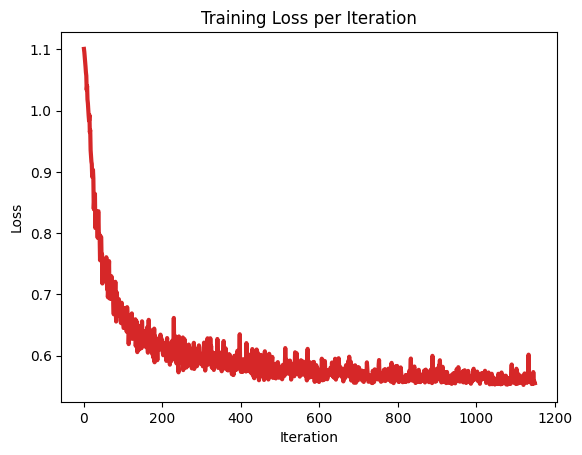

In [13]:
plt.plot(range(len(iter_losses)), iter_losses, color="tab:red", linewidth=3)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss per Iteration")
plt.show()

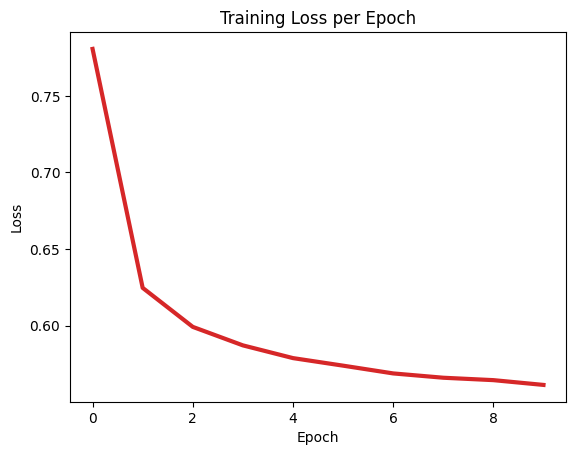

In [14]:
plt.plot(range(len(epoch_losses)), epoch_losses, color="tab:red", linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

### Evaluating the Model

In the evaluation step, eval() and no_grad() functions should be called. Some network layers such as BatchNorm and Dropout behave differently in the test phase. eval() function switches to the evaluation behavior in these layers. If the model will be trained later, the train() function should be called to switch back to the training behavior. [no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html) function disables the gradient calculations to reduce memory consumption during inference.

After inference is completed, the predictions are moved to the CPU, and both the predicted and the ground-truth labels are converted to a NumPy array. [np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) returns the index of the maximum output values (probabilities) of each sample. These indexes correspond to the IDs of the classes predicted.

In [15]:
model.eval()

num_pred_correct = 0
num_pred_total = 0
pred_class_list = []
gt_class_list = []

with torch.no_grad():
    for batch_image_class, batch_image_tensor in val_dataloader:
        if is_cuda_available:
            batch_image_tensor = batch_image_tensor.cuda()
        batch_outputs = model(batch_image_tensor)

        batch_image_class = batch_image_class.numpy()
        batch_outputs = batch_outputs.cpu().numpy()
        pred_classes = np.argmax(batch_outputs, axis=1)

        num_pred_total += len(pred_classes)
        num_pred_correct += (pred_classes == batch_image_class).sum()
    
        pred_class_list.extend(list(pred_classes))
        gt_class_list.extend(list(batch_image_class))

    print("Validation Accuracy: {}".format(num_pred_correct / num_pred_total))

Validation Accuracy: 0.9633333333333334


<Axes: >

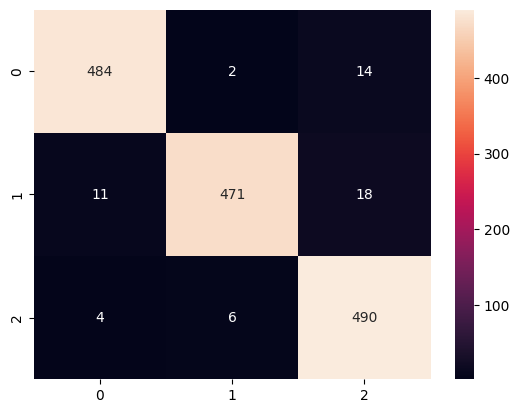

In [16]:
num_classes = 3
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)
for sample_id in range(len(gt_class_list)):
    pred_class = pred_class_list[sample_id]
    gt_class = gt_class_list[sample_id]
    confusion_matrix[gt_class, pred_class] += 1
sns.heatmap(confusion_matrix, annot=True, fmt="d")
# Class 0: Cat, Class 1: Dog, Class 2: Wild

---

**Author:** Ahmet Burak Yıldırım \[[GitHub](https://github.com/abyildirim)\] \[[LinkedIn](https://tr.linkedin.com/in/ahmet-burak-yildirim)\]

---